In [2]:
import os
import pickle
import datetime
import glob
import numpy as np
import random
from gensim.models.phrases import Phraser
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

def get_date_from_comment(comment):
    """Extract date from a comment dictionary"""
    try:
        return datetime.datetime.strptime(comment["date"], "%Y-%m-%d").date()
    except (KeyError, ValueError):
        try:
            return datetime.datetime.fromtimestamp(int(comment["timestamp"])).date()
        except (KeyError, ValueError):
            return None

def get_period(date):
    """Determine which time period a date belongs to"""
    if date is None:
        return None
    year = date.year
    if year <= 2016:
        return "before_2016"
    elif 2017 <= year <= 2020:
        return "2017_2020"
    elif 2021 <= year <= 2024:
        return "2021_2024"
    return None

def build_bigram_model(comments):
    """Build a bigram model for the given comments"""
    sentences = []
    for comment in comments:
        if "processed_text" in comment:
            sentences.append(comment["processed_text"])
    phrases = Phrases(sentences, min_count=10, threshold=10)
    return Phraser(phrases)

def apply_bigrams(comments, bigram_model):
    """Apply bigram model to comments"""
    processed = []
    for comment in comments:
        if "processed_text" in comment:
            processed.append(bigram_model[comment["processed_text"]])
    return processed

def create_or_update_model(period, comments, vector_size, window, min_count, workers, sg, epochs, existing_model=None):
    """Create a new model or update an existing one"""
    if existing_model is None:
        model = Word2Vec(
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            workers=workers,
            sg=sg,
            seed=23
        )
        model.build_vocab(comments)
        print(f"{period} vocabulary size: {len(model.wv.index_to_key)}")
    else:
        model = existing_model
        model.build_vocab(comments, update=True)
        print(f"{period} vocabulary size: {len(model.wv.index_to_key)}")
    model.train(comments, total_examples=len(comments), epochs=epochs)
    return model

def save_model(model, subreddit, period, model_dir, is_interim=False):
    """Save model to disk"""
    if is_interim:
        path = f"{model_dir}/interim/{subreddit}_{period}_interim.model"
    else:
        path = f"{model_dir}/{subreddit}_{period}.model"
    model.save(path)

def build_models_for_joint_corpus(
    base_data_dir,
    model_dir,
    vector_size=300,
    window=5,
    min_count=10,
    epochs=5,
    workers=16,
    sg=0,
    min_comments_to_train=10000,
    chunk_size=1000000,
    global_bigram_path=None
):
    time_periods = ["before_2016", "2017_2020", "2021_2024"]
    models = {period: None for period in time_periods}
    bigram_models = {period: None for period in time_periods}

    # Load global bigram model if exists
    if os.path.exists(global_bigram_path):
        print(f"Loading global bigram model from {global_bigram_path}")
        global_bigram_model = Phraser.load(global_bigram_path)
    else:
        print(f"Global bigram model not found at {global_bigram_path}, will train on each chunk.")
        global_bigram_model = None
        return

    # 合并两个社区的所有pickle文件
    import glob
    pickle_files = []
    for subreddit in ["democrats", "republican"]:
        pattern = f"{base_data_dir}/{subreddit}/{subreddit}_batch*.pkl"
        pickle_files.extend(sorted(glob.glob(pattern)))
    if not pickle_files:
        print(f"No pickle files found for joint corpus in {base_data_dir}/")
        return

    comments_by_period = {period: [] for period in time_periods}

    for file_path in pickle_files:
        try:
            with open(file_path, 'rb') as f:
                comments = pickle.load(f)
            print(f"Loaded {len(comments)} comments from {file_path}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue

        for comment in comments:
            date = get_date_from_comment(comment)
            period = get_period(date)
            if period:
                comments_by_period[period].append(comment)

        for period in time_periods:
            period_comments = comments_by_period[period]
            while len(period_comments) >= chunk_size:
                print(f"Processing chunk of {chunk_size} comments for {period}")
                chunk = period_comments[:chunk_size]
                period_comments = period_comments[chunk_size:]

                if global_bigram_model is not None:
                    bigram_model = global_bigram_model
                else:
                    bigram_model = build_bigram_model(chunk)
                bigram_models[period] = bigram_model
                processed_chunk = apply_bigrams(chunk, bigram_model)

                if len(processed_chunk) > min_comments_to_train:
                    model = create_or_update_model(
                        period, processed_chunk, vector_size, window, min_count, workers, sg, epochs, models[period]
                    )
                    models[period] = model
                    # 保存联合模型
                    save_model(model, "joint", period, model_dir, is_interim=True)
            comments_by_period[period] = period_comments

    # Process any remaining comments
    for period, remaining_comments in comments_by_period.items():
        if len(remaining_comments) > min_comments_to_train:
            print(f"Processing final {len(remaining_comments)} comments for {period}")
            if global_bigram_model is not None:
                bigram_model = global_bigram_model
            else:
                bigram_model = build_bigram_model(remaining_comments)
            bigram_models[period] = bigram_model
            processed_chunk = apply_bigrams(remaining_comments, bigram_model)
            model = create_or_update_model(
                period, processed_chunk, vector_size, window, min_count, workers, sg, epochs, models[period]
            )
            models[period] = model
            save_model(model, "joint", period, model_dir, is_interim=False)
        else:
            print(f"Skipping final {len(remaining_comments)} comments for {period} (less than minimum required)")

    # Save final models
    for period, model in models.items():
        if model is not None:
            save_model(model, "joint", period, model_dir, is_interim=False)
    print(f"Joint model saved to {model_dir}")
    print(f"Completed building joint models for democrats + republican")


# def main():
#     model_dir = "models/chunk_4"
#     global_bigram_path = "models/bigram/political_bigram_1.phr"
#     os.makedirs(model_dir, exist_ok=True)
#     os.makedirs(f"{model_dir}/interim", exist_ok=True)
#     random.seed(23)
#     np.random.seed(23)
#     build_models_for_joint_corpus(
#         base_data_dir="processed_comments_2",
#         model_dir=model_dir,
#         vector_size=300,
#         window=5,
#         min_count=10,
#         epochs=5,
#         workers=16,
#         sg=0,
#         min_comments_to_train=10000,
#         chunk_size=1000000,
#         global_bigram_path=global_bigram_path
#     )

# if __name__ == "__main__":
#     main()

# Changes made:
# Using global bigram model, set min_count=10

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser
import os
import pickle
import glob
import numpy as np

# load target words
def get_period_years(period):
    if period == "before_2016":
        return [str(y) for y in range(2011, 2017)]
    elif period == "2017_2020":
        return [str(y) for y in range(2017, 2021)]
    elif period == "2021_2024":
        return [str(y) for y in range(2021, 2025)]
    else:
        return []

def get_target_words(freq_file1, freq_file2, period):
    years = get_period_years(period)
    df1 = pd.read_csv(freq_file1, index_col=0)
    df2 = pd.read_csv(freq_file2, index_col=0)

    df1 = df1[years].fillna(0)
    df2 = df2[years].fillna(0)

    mask1 = (df1[years] >= 1).all(axis=1) & (df1[years].sum(axis=1) > 10)
    mask2 = (df2[years] >= 1).all(axis=1) & (df2[years].sum(axis=1) > 10)
    target_words = set(df1.index[mask1]) & set(df2.index[mask2])
    return target_words

dem_file = "word_freq_yearly/democrats_withstopwords_year.csv"
rep_file = "word_freq_yearly/republican_withstopwords_year.csv"
period = "before_2016"


# load models
model_dir = "models/chunk_4"
periods = ["before_2016", "2017_2020", "2021_2024"]
joint_model = {}
for period in periods:
    path = f"{model_dir}/joint_{period}.model"
    if os.path.exists(path):
        joint_model[period] = Word2Vec.load(path)
    else:
        print(f"Model not found: {path}")

# extract context vectors
def extract_context_vectors(base_data_dir, subreddit, bigram_model, target_words, period, model):
    pattern = f"{base_data_dir}/{subreddit}/{subreddit}_batch*.pkl"
    context_vectors = {w: [] for w in target_words}
    for file in sorted(glob.glob(pattern)):
        with open(file, 'rb') as f:
            comments = pickle.load(f)
            for comment in comments:
                date = get_date_from_comment(comment)
                p = get_period(date)
                if p != period or "processed_text" not in comment:
                    continue
                tokens = bigram_model[comment["processed_text"]]
                for idx, token in enumerate(tokens):
                    if token in target_words:
                        left = max(0, idx-5)
                        right = min(len(tokens), idx+6)
                        context = [t for i, t in enumerate(tokens[left:right]) if i != idx and t in model.wv]
                        if context:
                            vec = np.mean([model.wv[t] for t in context], axis=0)
                            context_vectors[token].append(vec)
    return context_vectors

# load bigram model
global_bigram_path = "models/bigram/political_bigram_1.phr"
bigram_model = Phraser.load(global_bigram_path)

base_data_dir = "processed_comments_2"
subreddits = ["democrats", "republican"]
all_stats = {}
for subreddit in subreddits:
    all_stats[subreddit] = {}
    for period in periods:
        print(f"Extracting context vectors for {subreddit} {period} ...")
        target_words = get_target_words(dem_file, rep_file, period)
        context_vectors = extract_context_vectors(
            base_data_dir, subreddit, bigram_model, target_words, period, joint_model[period]
        )

        # calculate distribution statistics
        stats = {}
        for word, vecs in context_vectors.items():
            if len(vecs) == 0: continue
            arr = np.stack(vecs)
            centroid = arr.mean(axis=0)
            variance = arr.var(axis=0).mean()
            stats[word] = {"centroid": centroid, "variance": variance}
        all_stats[subreddit][period] = stats

# calculate polarization measures
def polarization_measure(stats1, stats2):
    results = {}
    for word in stats1:
        if word not in stats2: continue
        c1 = stats1[word]["centroid"]
        c2 = stats2[word]["centroid"]
        cos_dist = cosine(c1, c2)
        v1 = stats1[word]["variance"]
        v2 = stats2[word]["variance"]
        kl_div = np.log(v2/v1) + (v1 + np.sum((c1-c2)**2))/v2 - 1
        results[word] = {"cosine": cos_dist, "kl": kl_div}
    return results

polarization_results = {}
for period in periods:
    polarization_results[period] = polarization_measure(
        all_stats["democrats"][period], all_stats["republican"][period]
    )

# display some results
for period in periods:
    print(f"\nPolarization for period: {period}")
    df = pd.DataFrame([
        {"word": w, "cosine": v["cosine"], "kl": v["kl"]}
        for w, v in polarization_results[period].items()
    ]).sort_values("cosine", ascending=False)
    df.to_csv(f"output/contextual/polarization_{period}_filtered.csv", index=False)
    print(df.head(20))

Extracting context vectors for democrats before_2016 ...
Extracting context vectors for democrats 2017_2020 ...
Extracting context vectors for democrats 2021_2024 ...
Extracting context vectors for republican before_2016 ...
Extracting context vectors for republican 2017_2020 ...
Extracting context vectors for republican 2021_2024 ...


C:\Users\cyyua\AppData\Local\Temp\ipykernel_8848\856753732.py:110: RuntimeWarning: divide by zero encountered in log
  kl_div = np.log(v2/v1) + (v1 + np.sum((c1-c2)**2))/v2 - 1
C:\Users\cyyua\AppData\Local\Temp\ipykernel_8848\856753732.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  kl_div = np.log(v2/v1) + (v1 + np.sum((c1-c2)**2))/v2 - 1
C:\Users\cyyua\AppData\Local\Temp\ipykernel_8848\856753732.py:110: RuntimeWarning: invalid value encountered in scalar add
  kl_div = np.log(v2/v1) + (v1 + np.sum((c1-c2)**2))/v2 - 1
C:\Users\cyyua\AppData\Local\Temp\ipykernel_8848\856753732.py:110: RuntimeWarning: invalid value encountered in scalar divide
  kl_div = np.log(v2/v1) + (v1 + np.sum((c1-c2)**2))/v2 - 1



Polarization for period: before_2016
            word    cosine          kl
2915   hampshire  0.999878         inf
1487   francisco  0.875412  581.573425
3198       faire  0.824715  677.072937
4146        karl  0.799468  314.056488
1245         wal  0.757016  606.334534
1439        sean  0.742372  221.278412
4223         san  0.736907   98.319038
489          ayn  0.675678         NaN
1883  huffington  0.652531         inf
833          bin  0.641250  187.659668
4535        peak  0.635687  363.519928
3479       sachs  0.632687  438.167694
4439      bumper  0.622607  729.584229
1441      herman  0.619068         inf
2587    partiers  0.612991         NaN
337      michele  0.597186  212.327423
1671       atlas  0.593700  230.466690
3868         hoo  0.575502  107.163773
3958      grover  0.558735  235.256271
1757    flopping  0.555473  302.520142

Polarization for period: 2017_2020
            word    cosine          kl
9453      grande  1.024411         inf
10506        hoo  0.977452  4

In [8]:
import pandas as pd
import glob
import os
import os
import pickle
import glob
import pandas as pd
from collections import Counter

def get_top_n_words_from_csv(csv_path, n=2000):
    df = pd.read_csv(csv_path)
    return set(df.sort_values("frequency", ascending=False).head(n)["word"])

def get_global_overlap_words(csv_dir, n=2000):
    """
    Find the overlap words among the top n words of all subreddits in csv_dir.
    """
    csv_files = glob.glob(os.path.join(csv_dir, "*_word_freq.csv"))
    top_words_list = [get_top_n_words_from_csv(f, n) for f in csv_files]
    if not top_words_list:
        return set()
    overlap = set.intersection(*top_words_list)
    return overlap

overlap = get_global_overlap_words("word_freq_csv", n=5000)
print(overlap)

def load_google_vocab(filepath, top_n=5000):
    with open(filepath, "r", encoding="utf-8") as f:
        words = [line.strip() for line in f.readlines()]
    return set(words[:top_n])

google_vocab = load_google_vocab("word_freq_csv/google-10000-english-usa.txt", top_n=2000)
overlap_with_google = overlap & google_vocab

import gensim

input_dir = "models/chunk_3"
democrats_before_2016 = gensim.models.Word2Vec.load(f"{input_dir}/democrats_before_2016.model")
democrats_2017_2020 = gensim.models.Word2Vec.load(f"{input_dir}/democrats_2017_2020.model")
democrats_2021_2024 = gensim.models.Word2Vec.load(f"{input_dir}/democrats_2021_2024.model")
republican_before_2016 = gensim.models.Word2Vec.load(f"{input_dir}/republican_before_2016.model")
republican_2017_2020 = gensim.models.Word2Vec.load(f"{input_dir}/republican_2017_2020.model")
republican_2021_2024 = gensim.models.Word2Vec.load(f"{input_dir}/republican_2021_2024.model")

import nltk
from nltk.corpus import stopwords

# nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

model_list = [
    ("democrats_before_2016", democrats_before_2016),
    ("democrats_2017_2020", democrats_2017_2020),
    ("democrats_2021_2024", democrats_2021_2024),
    ("republican_before_2016", republican_before_2016),
    ("republican_2017_2020", republican_2017_2020),
    ("republican_2021_2024", republican_2021_2024),
]

all_model_vocab = set.intersection(*(set(model.wv.key_to_index.keys()) for _, model in model_list))

all_models_google_overlap = all_model_vocab & overlap_with_google

all_models_stopwords_overlap = all_model_vocab & stop_words

all_models_union = all_models_google_overlap | all_models_stopwords_overlap

import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser
import os
import pickle
import glob
import numpy as np

# load target words
words_df = pd.read_csv("output/political_words_tfidf_diff.csv", header=None)
target_words = all_models_union

# load models
model_dir = "models/chunk_4"
periods = ["before_2016", "2017_2020", "2021_2024"]
joint_model = {}
for period in periods:
    path = f"{model_dir}/joint_{period}.model"
    if os.path.exists(path):
        joint_model[period] = Word2Vec.load(path)
    else:
        print(f"Model not found: {path}")

# extract context vectors
def extract_context_vectors(base_data_dir, subreddit, bigram_model, target_words, period, model):
    pattern = f"{base_data_dir}/{subreddit}/{subreddit}_batch*.pkl"
    context_vectors = {w: [] for w in target_words}
    for file in sorted(glob.glob(pattern)):
        with open(file, 'rb') as f:
            comments = pickle.load(f)
            for comment in comments:
                date = get_date_from_comment(comment)
                p = get_period(date)
                if p != period or "processed_text" not in comment:
                    continue
                tokens = bigram_model[comment["processed_text"]]
                for idx, token in enumerate(tokens):
                    if token in target_words:
                        left = max(0, idx-5)
                        right = min(len(tokens), idx+6)
                        context = [t for i, t in enumerate(tokens[left:right]) if i != idx and t in model.wv]
                        if context:
                            vec = np.mean([model.wv[t] for t in context], axis=0)
                            context_vectors[token].append(vec)
    return context_vectors

# load bigram model
global_bigram_path = "models/bigram/political_bigram_1.phr"
bigram_model = Phraser.load(global_bigram_path)

base_data_dir = "processed_comments_2"
subreddits = ["democrats", "republican"]
all_stats = {}
for subreddit in subreddits:
    all_stats[subreddit] = {}
    for period in periods:
        print(f"Extracting context vectors for {subreddit} {period} ...")
        context_vectors = extract_context_vectors(
            base_data_dir, subreddit, bigram_model, target_words, period, joint_model[period]
        )

        # calculate distribution statistics
        stats = {}
        for word, vecs in context_vectors.items():
            if len(vecs) == 0: continue
            arr = np.stack(vecs)
            centroid = arr.mean(axis=0)
            variance = arr.var(axis=0).mean()
            stats[word] = {"centroid": centroid, "variance": variance}
        all_stats[subreddit][period] = stats

# calculate polarization measures
def polarization_measure(stats1, stats2):
    results = {}
    for word in stats1:
        if word not in stats2: continue
        c1 = stats1[word]["centroid"]
        c2 = stats2[word]["centroid"]
        cos_dist = cosine(c1, c2)
        v1 = stats1[word]["variance"]
        v2 = stats2[word]["variance"]
        kl_div = np.log(v2/v1) + (v1 + np.sum((c1-c2)**2))/v2 - 1
        results[word] = {"cosine": cos_dist, "kl": kl_div}
    return results

polarization_results = {}
for period in periods:
    polarization_results[period] = polarization_measure(
        all_stats["democrats"][period], all_stats["republican"][period]
    )

# display some results
for period in periods:
    print(f"\nPolarization for period: {period}")
    df = pd.DataFrame([
        {"word": w, "cosine": v["cosine"], "kl": v["kl"]}
        for w, v in polarization_results[period].items()
    ]).sort_values("cosine", ascending=False)
    df.to_csv(f"output/tests_{period}.csv", index=False)
    print(df.head(20))


{'role', 'gotta', 'mainly', 'ear', 'affected', 'tool', 'likely', 'money', 'alone', 'held', 'understanding', 'dunno', 'swim', 'accord', 'pour', 'via', 'physical', 'put', 'youre', 'tonight', 'enter', 'process', 'trigger', 'happen', 'cup', 'everyday', 'modern', 'practice', 'skip', 'degree', 'badly', 'highlight', 'wind', 'push', 'genuine', 'odd', 'factor', 'contract', 'fuel', 'holiday', 'last', 'apply', 'odds', 'chase', 'empty', 'joke', 'aside', 'lie', 'brick', 'religious', 'current', 'war', 'grab', 'talk', 'even', 'faster', 'false', 'lead', 'manage', 'yeah', 'apology', 'aware', 'wild', 'weather', 'region', 'topic', 'grand', 'fat', 'spread', 'realistically', 'spoil', 'invest', 'remains', 'miserable', 'internet', 'live', 'phone', 'direction', 'real', 'excellent', 'consumer', 'peace', 'express', 'dance', 'tiny', 'gold', 'yes', 'cycle', 'concern', 'usa', 'short', 'lunch', 'battle', 'internal', 'metal', 'bell', 'log', 'surprisingly', 'bubble', 'would', 'iirc', 'anxiety', 'yell', 'brain', 'prop

In [1]:
import matplotlib.pyplot as plt

# visualize cosine distance distributions
plt.figure(figsize=(10, 6))
for period in periods:
    df = pd.DataFrame([
        {"word": w, "cosine": v["kl"]}
        for w, v in polarization_results[period].items()
    ])
    plt.hist(df["cosine"], bins=50, alpha=0.5, label=f"{period} (mean={df['cosine'].mean():.3f})")
    plt.axvline(df["cosine"].mean(), color='k', linestyle='--')

plt.title("Cosine Distance Distribution of Political Words (Democrats vs Republican)")
plt.xlabel("Cosine Distance")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'periods' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
import pandas as pd
w = pd.read_csv("output/contextual/polarization_2021_2024.csv")
w['cosine'].mean()

0.012892533505905912

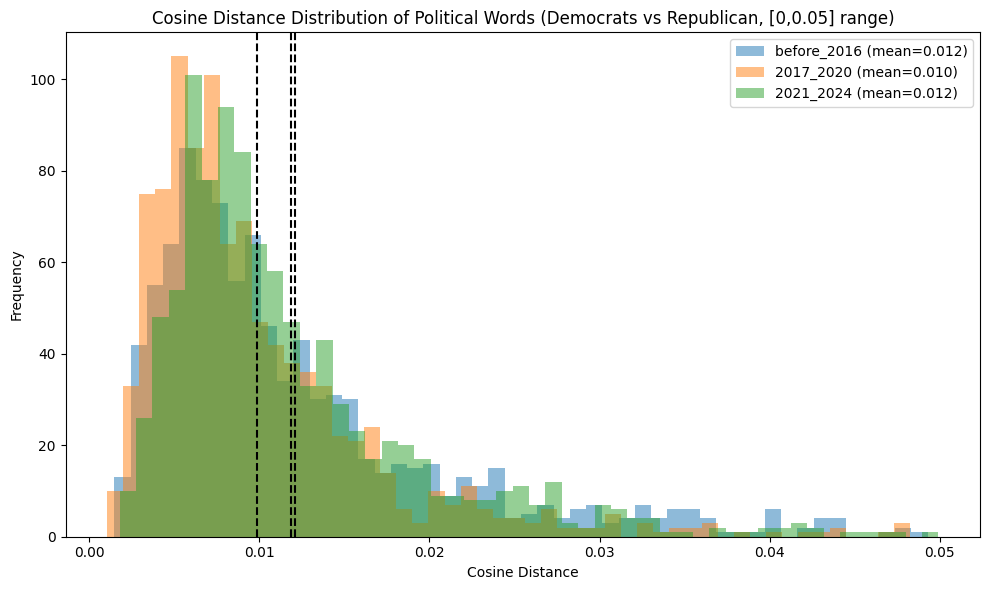

In [ ]:
import matplotlib.pyplot as plt

# visualize cosine distance distributions (zoomed in)
plt.figure(figsize=(10, 6))
for period in periods:
    df = pd.DataFrame([
        {"word": w, "cosine": v["cosine"]}
        for w, v in polarization_results[period].items()
    ])
    df = df[(df["cosine"] >= 0) & (df["cosine"] <= 0.05)]  # 只显示0~0.05
    plt.hist(df["cosine"], bins=50, alpha=0.5, label=f"{period} (mean={df['cosine'].mean():.3f})")
    plt.axvline(df["cosine"].mean(), color='k', linestyle='--')

plt.title("Cosine Distance Distribution of Political Words (Democrats vs Republican, [0,0.05] range)")
plt.xlabel("Cosine Distance")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

0.017367246091095953